# Stock Price Prediction (NIFTY 50)

This project focuses on predicting **NIFTY 50 stock prices** using both **Machine Learning (ML)** and **Deep Learning (DL)** approaches.  
The workflow involves preparing time-series data, training multiple models, and comparing their performance.

---

## Pipeline Overview

1. **Data Loading**
   - Load stock price data (`data.csv`).
   - Features: `Open`, `Close`, `High`, `Low`.

2. **Data Preparation**
   - Create supervised learning datasets using sliding windows (30–250 days).
   - Generate `(X, y)` pairs for each feature.

3. **Modeling**
   - **Machine Learning Models**  
     - Linear: `LinearRegression`, `Ridge`, `Lasso`  
     - Tree-based: `RandomForest`, `GradientBoosting`, `XGBoost`, `LightGBM`  
     - Others: `SVR`, `KNN`
   - **Deep Learning Models**  
     - RNN, LSTM, GRU, Bidirectional LSTM (Keras Sequential API)

4. **Training**
   - Train models on rolling window datasets.
   - Evaluate using **MAE** and **RMSE**.

5. **Evaluation & Comparison**
   - Store results for all models.
   - Compare ML vs DL models for different input window sizes.

---

## Key Highlights
- Hybrid pipeline combining **classical ML** and **neural networks**.  
- Uses **multiple time horizons (30–250 days)** for robust prediction.  
- Tracks **training and testing errors** to evaluate generalization.  

### 1. Import Libraries & Dataset

1. **Import Libraries**
   - `numpy`, `pandas`: data handling  
   - `tqdm`: progress bars  
   - `sklearn`: machine learning models & metrics  
   - `xgboost`, `lightgbm`: gradient boosting models  
   - `warnings`: ignore warnings  

2. **Load Dataset**
   - `df = pd.read_csv('data.csv')` → load data from CSV  
   - `df.head()` → preview first 5 rows  

3. **Models Imported**
   - Linear: `LinearRegression`, `Ridge`, `Lasso`  
   - Tree-based: `RandomForestRegressor`, `GradientBoostingRegressor`  
   - Others: `SVR`, `KNeighborsRegressor`, `XGBRegressor`, `LGBMRegressor`  

4. **Metrics Imported**
   - `mean_absolute_error`, `mean_squared_error` → to evaluate model performance  


In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/Nifty 50 Historical Data.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,26-09-2025,"24,654.70","24,818.55","24,854.10","24,630.35",291.54M,-0.95%
1,25-09-2025,"24,890.85","25,034.50","25,092.70","24,878.30",342.53M,-0.66%
2,24-09-2025,"25,056.90","25,108.75","25,149.85","25,027.45",244.38M,-0.45%
3,23-09-2025,"25,169.50","25,209.00","25,261.90","25,084.65",299.20M,-0.13%
4,22-09-2025,"25,202.35","25,238.10","25,331.70","25,151.05",254.51M,-0.49%


### 2. Data Preparation

1. **Train-Test Split**
   - `train_test_split()` → split data into training & testing sets.  

2. **Models List**
   - A collection of regressors:  
     - Linear: `LinearRegression`, `Ridge`, `Lasso`  
     - Tree-based: `RandomForestRegressor`, `GradientBoostingRegressor`  
     - Others: `SVR`, `KNeighborsRegressor`, `XGBRegressor`, `LGBMRegressor`  

3. **Training Loop**
   - For each model:  
     - `fit()` → train on training data  
     - `predict()` → generate predictions on test data  

4. **Evaluation**
   - Metrics used:  
     - `mean_absolute_error`  
     - `mean_squared_error`  
   - Store results for comparison of all models.  

In [ ]:
#rename price to close
df.rename(columns={'Price': 'Close'}, inplace=True)

In [ ]:
df.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,26-09-2025,"24,654.70","24,818.55","24,854.10","24,630.35",291.54M,-0.95%
1,25-09-2025,"24,890.85","25,034.50","25,092.70","24,878.30",342.53M,-0.66%
2,24-09-2025,"25,056.90","25,108.75","25,149.85","25,027.45",244.38M,-0.45%
3,23-09-2025,"25,169.50","25,209.00","25,261.90","25,084.65",299.20M,-0.13%
4,22-09-2025,"25,202.35","25,238.10","25,331.70","25,151.05",254.51M,-0.49%


In [ ]:
def return_pairs(column, days):
    # Convert the column to numeric, coercing errors to NaN
    prices = pd.to_numeric(column.str.replace(',', ''), errors='coerce').tolist()
    X = []
    y = []
    for i in range(len(prices) - days):
        # Only append if both the window and the target are not NaN
        if not any(pd.isna(prices[i:i+days])) and not pd.isna(prices[i+days]):
            X.append(prices[i:i+days])
            y.append(prices[i+days])
    return np.array(X), np.array(y)

target_columns =  ['Open', 'Close', 'High', 'Low']
day_chunks =  [30, 45, 60, 90, 120, 150 ,200, 250]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

### 3. Define Neural Network Models

1. **Imports**
   - `Sequential` → build models layer-by-layer  
   - Layers: `Dense`, `SimpleRNN`, `LSTM`, `GRU`, `Bidirectional`  

2. **Model Builder Functions**
   - `build_rnn(input_shape)`  
     - Simple RNN with 50 units → `Dense(1)` output  
   - `build_lstm(input_shape)`  
     - LSTM with 50 units → `Dense(1)` output  
   - `build_gru(input_shape)`  
     - GRU with 50 units → `Dense(1)` output  
   - `build_bilstm(input_shape)`  
     - Bidirectional LSTM with 50 units → `Dense(1)` output  

3. **Compilation**
   - Optimizer: `adam`  
   - Loss: `mse` (Mean Squared Error)  

4. **Purpose**
   - All models → designed for **regression tasks on sequential data**.  

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)   # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### 4. Define ML Models

1. **ml_models (Traditional ML)**
   - A list of tuples: (name, model instance)  
   - Includes:  
     - Linear models → `LinearRegression`, `Ridge`, `Lasso`  
     - Tree-based → `RandomForest`, `GradientBoosting`  
     - Others → `SVR`, `KNN`, `XGBoost`, `LightGBM`  

2. **dl_models (Deep Learning)**
   - A dictionary: {name: builder function}  
   - Includes:  
     - `"RNN"` → `build_rnn`  
     - `"LSTM"` → `build_lstm`  
     - `"GRU"` → `build_gru`  
     - `"Bidirectional_LSTM"` → `build_bilstm`  

3. **Purpose**
   - `ml_models`: ready-to-train classical ML regressors  
   - `dl_models`: functions that return compiled neural nets (when given `input_shape`)  

In [ ]:
ml_models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("RandomForest", RandomForestRegressor()),
    ("GradientBoosting", GradientBoostingRegressor()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor()),
    ("XGBoost", XGBRegressor(verbosity=0)),
    ("LightGBM", LGBMRegressor(verbosity=0))
]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

### 5. Model Training

1. **Initialize**
   - `trained_models = {}` → store results of all models  

2. **Iterate over Data Pairs**
   - For each `(X, y)` in `chunk_pairs`  
   - Extract features `X_data` and target `y_data` from `chunked_data`  
   - Split → `train_test_split` (90% train, 10% test)  

3. **Train ML Models**
   - Loop through `ml_models`  
   - Use `deepcopy` to avoid reusing fitted models  
   - `fit()` on training data  
   - Predict on train & test sets  
   - Save model + metrics:  
     - `train_mae`, `train_rmse`  
     - `test_mae`, `test_rmse`  

4. **Prepare Data for DL**
   - Expand dims → shape becomes `(samples, timesteps, features)`  

5. **Train DL Models**
   - Loop through `dl_models`  
   - Build model with correct input shape  
   - Train for 10 epochs, batch size = 8  
   - Predict on train & test  
   - Save model + metrics (same as ML)  

6. **Final Output**
   - `trained_models` → dictionary with all trained models & evaluation scores  


In [ ]:
trained_models = {}

for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # ML models
    for model_name, model in tqdm(ml_models):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL models
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=10, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


### 6. Saving Model Statistics

1. **Collect Results**
   - Convert `trained_models` dict → list of dicts  
   - Each row = {"Model": model_name, metrics...}  

2. **Create DataFrame**
   - `results_df = pd.DataFrame([...])`  
   - Columns: `Model`, `train_mae`, `train_rmse`, `test_mae`, `test_rmse`  

3. **Sort Results**
   - Sort by `test_mae` (ascending → best first)  

4. **Display**
   - Show top 50 models with lowest test MAE  

In [ ]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True).head(50)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
307,LightGBM_High_250,LGBMRegressor(verbosity=0),20.028585,30.280062,97.271132,129.322022
305,KNN_High_250,KNeighborsRegressor(),73.171278,98.062143,101.542200,128.674940
261,Ridge_High_120,Ridge(),98.168956,129.619452,101.588444,141.362936
260,LinearRegression_High_120,LinearRegression(),98.168956,129.619452,101.588446,141.362937
302,RandomForest_High_250,"(DecisionTreeRegressor(max_features=1.0, rando...",41.576238,59.651718,102.751565,133.582456
292,KNN_High_200,KNeighborsRegressor(),74.026628,98.971764,103.192857,133.486460
274,Ridge_High_150,Ridge(),96.099189,127.301135,105.228789,135.221464
273,LinearRegression_High_150,LinearRegression(),96.099190,127.301135,105.228790,135.221467
281,LightGBM_High_150,LGBMRegressor(verbosity=0),25.480960,36.229485,105.582051,136.364897
222,Ridge_High_45,Ridge(),102.525312,143.201421,105.632759,136.338482


### 7. Top 50 Models

1. **Select Top 50**
   - Sort `results_df` by `test_mae`  
   - Keep best 50 models  

2. **Create Figure**
   - `plt.figure(figsize=(25, 8))` → wide chart for readability  

3. **Plot Lines**
   - Plot `train_mae` with markers  
   - Plot `test_mae` with markers  

4. **Customize**
   - Rotate x-axis labels (75°) for clarity  
   - Add labels (x, y), title, legend, and grid  
   - `tight_layout()` → avoid overlap  

5. **Show Chart**
   - `plt.show()` → display line chart comparing Train vs Test MAE

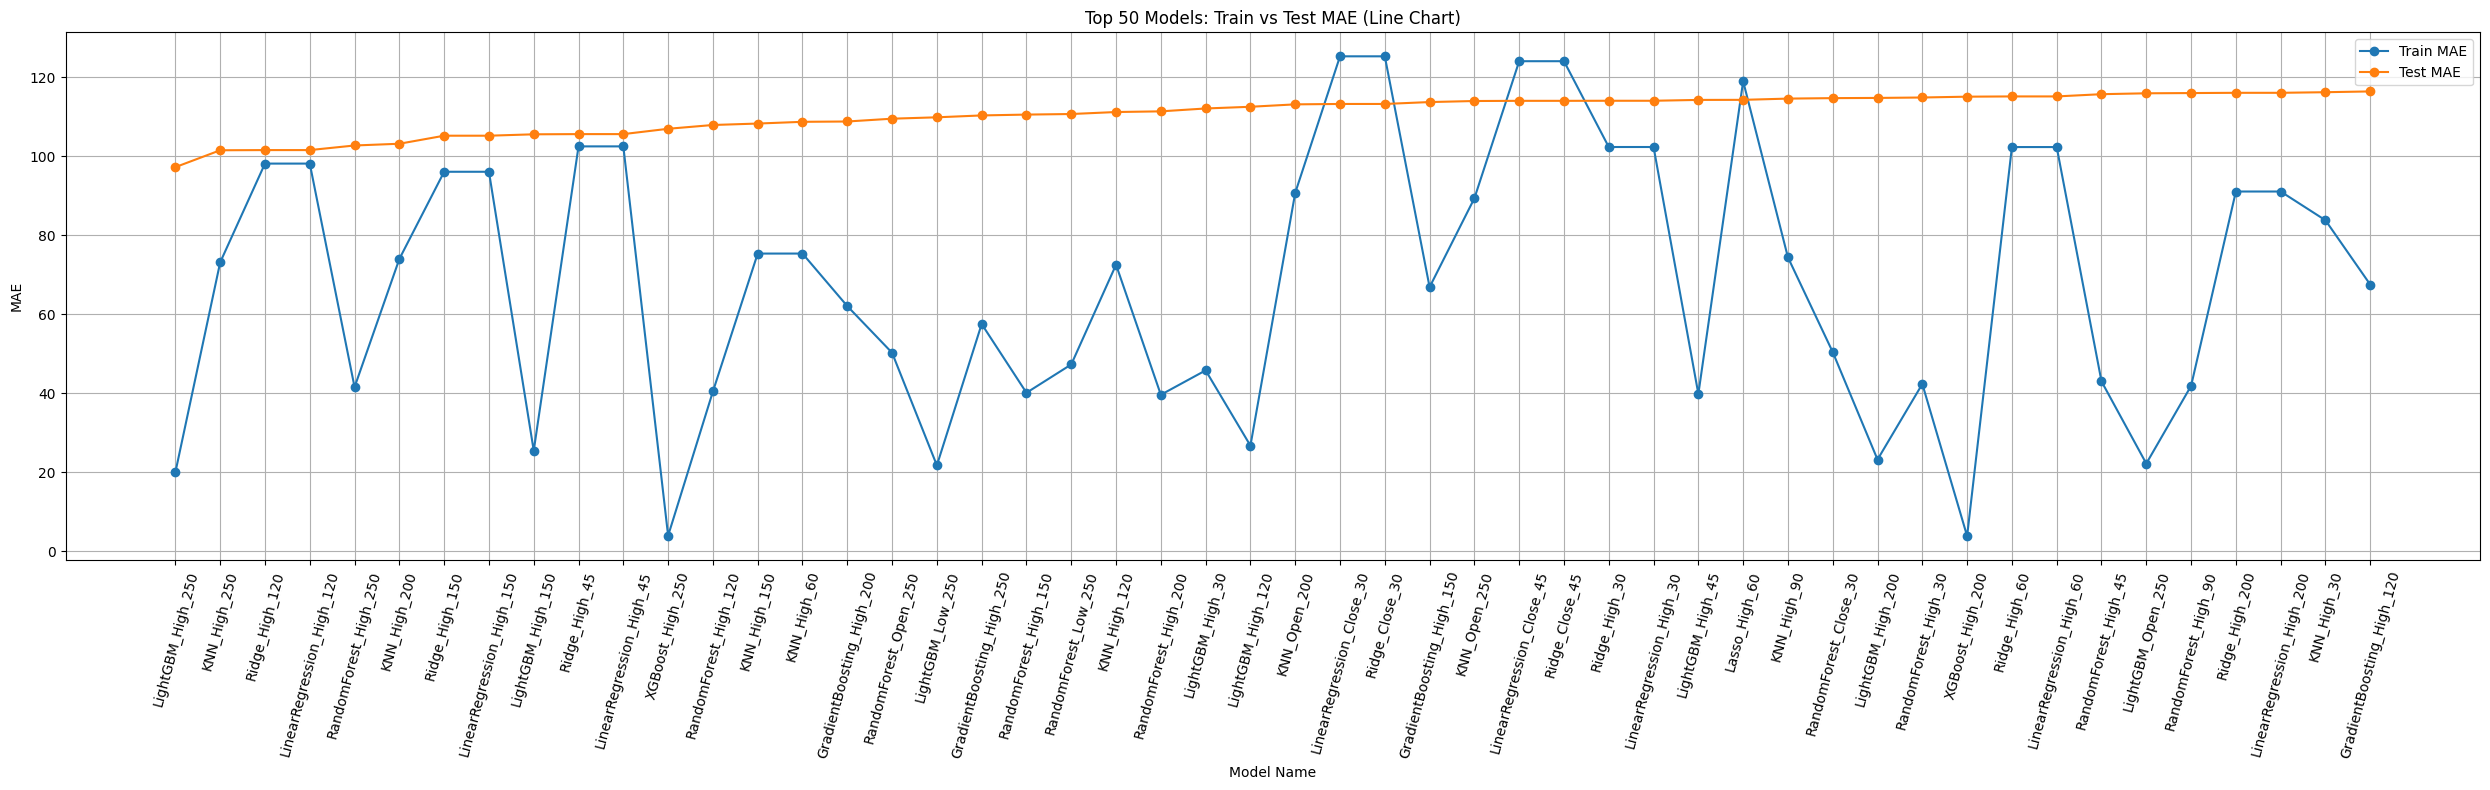

In [ ]:
import matplotlib.pyplot as plt


top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)

plt.figure(figsize=(25, 8))
plt.plot(top_50['Model'], top_50['train_mae'], marker='o', label='Train MAE')

plt.plot(top_50['Model'], top_50['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Top 50 Models: Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 8. Relation btw. No of Input Days and Model Performance

1. **Extract Time Windows**
   - From each model name in `top_50`  
   - Split string by `_` → take last part (time window)  

2. **Count Frequencies**
   - `value_counts()` → count models per time window  
   - Sort by count (descending)  

3. **Plot Bar Chart**
   - X-axis: time windows  
   - Y-axis: number of models in Top 50  

4. **Customize**
   - Add labels (x, y), title  
   - Grid only on Y-axis for readability  
   - `tight_layout()` → clean layout  

5. **Show Chart**
   - `plt.show()` → display bar chart of time-window frequencies  

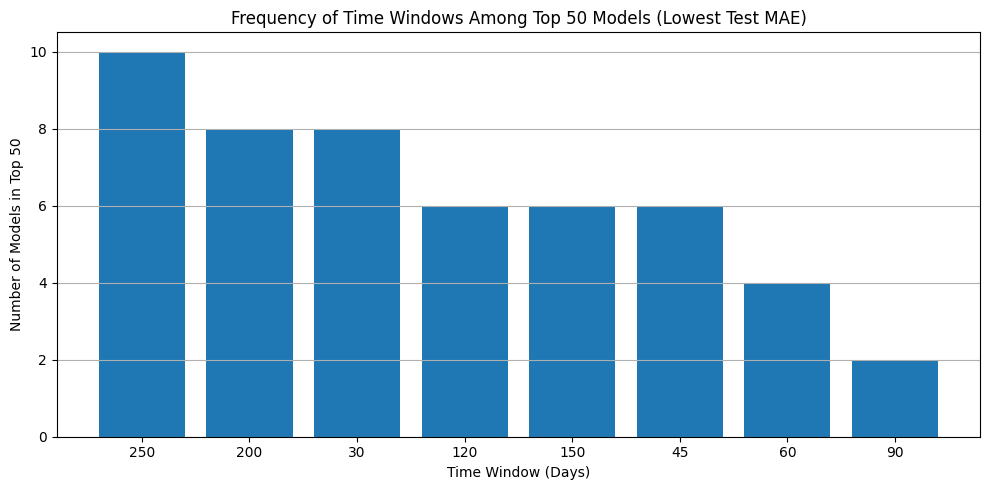

In [ ]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
time_windows = pd.Series([i.split('_')[-1] for i in top_50['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)

# Labels and aesthetics
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 50')
plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 9. Which column(HIGH/LOW/CLOSE/OPEN) should be taken into consideration for model building?

1. **Select Top 50 Models**
   - Sort by `test_mae` → best 50 models  

2. **Extract Target Column**
   - From model names → split by `_`  
   - Take second last part as target column name  

3. **Count Frequencies**
   - `value_counts()` → count occurrences of each target  
   - Sort by frequency (descending)  

4. **Plot Bar Chart**
   - X-axis: target column names  
   - Y-axis: number of models in Top 50  

5. **Customize**
   - Add labels, title  
   - Grid on Y-axis for readability  
   - Use `tight_layout()` to prevent label overlap  

6. **Show Chart**
   - `plt.show()` → display bar chart of target column frequencies

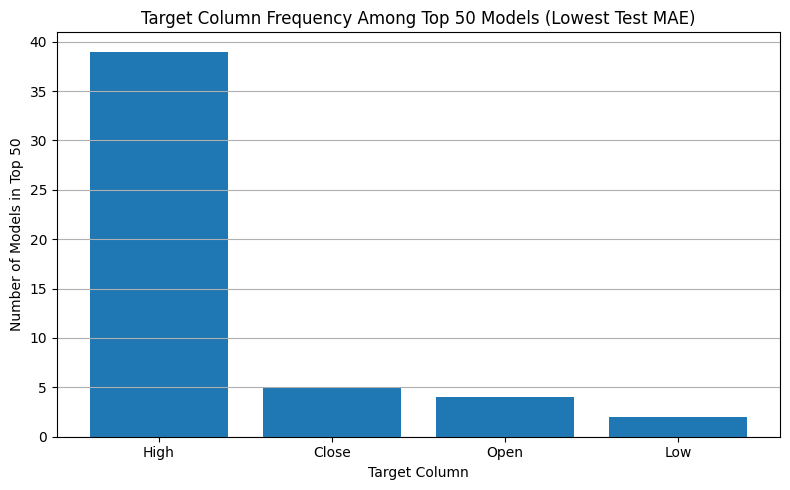

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract target columns from top 50 models
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
target_columns = pd.Series([i.split('_')[-2] for i in top_50['Model']])
target_counts = target_columns.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values)

# Labels and aesthetics
plt.xlabel('Target Column')
plt.ylabel('Number of Models in Top 50')
plt.title('Target Column Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 10. Which model works in general better on this task?

1. **Select Top 50 Models**
   - Sort `results_df` by `test_mae`  
   - Keep best 50 models  

2. **Extract Model Types**
   - From model names → split by `_`  
   - Take the first part as model type (e.g., LinearRegression, LSTM)  

3. **Count Frequencies**
   - `value_counts()` → count occurrences of each model type  
   - Sort counts in descending order  

4. **Plot Bar Chart**
   - X-axis: model types  
   - Y-axis: number of models in Top 50  

5. **Customize**
   - Add axis labels, title  
   - Grid only on Y-axis  
   - `tight_layout()` for spacing  

6. **Show Chart**
   - `plt.show()` → display bar chart of model type distribution  

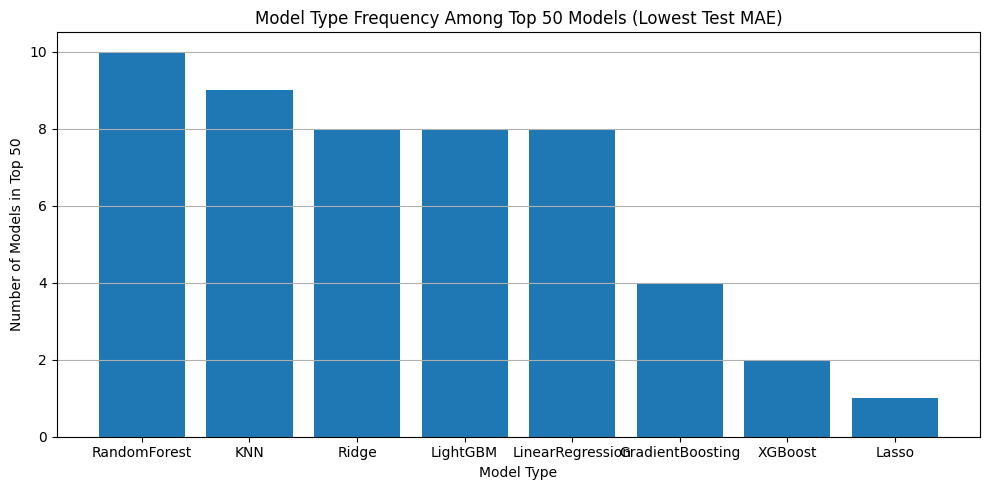

In [ ]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
model_types = pd.Series([i.split('_')[0] for i in top_50['Model']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values)

# Labels and aesthetics
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 50')
plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 11. Saving Models

1. **Save Results Table**
   - `results_df.to_csv('models.csv')` → save metrics as CSV  

2. **Save Trained Models**
   - `joblib.dump(trained_models, 'trained_models.joblib')`  
   - Stores all fitted ML + DL models + their metrics  

3. **Load Models**
   - `loaded_models = joblib.load('trained_models.joblib')`  
   - Reload models/metrics into memory for reuse  

In [ ]:
import joblib

results_df.to_csv('models.csv')
joblib.dump(trained_models, 'trained_models.joblib')

loaded_models = joblib.load('trained_models.joblib')

### 12. Loading Saved Models

1. **Access Specific Model**
   - `loaded_models['KNN_High_90']`  
   - Retrieves dictionary with:
     - Trained model object  
     - Train/Test MAE & RMSE metrics  

2. **Extract Model**
   - `model = loaded_models['KNN_High_90']['model']`  
   - Assigns the trained KNN regressor to `model` variable  
   - Now can be used for `.predict()` on new data  

In [ ]:
loaded_models['KNN_High_90']
model = loaded_models['KNN_High_90']['model']
model

KNeighborsRegressor()

### 13. Model Inference

1. **Inspect Input Sample**
   - `print(chunked_data['X_Open_90'][5])`  
   - Displays the 6th sample from feature set `X_Open_90`  

2. **Make Prediction**
   - `model.predict([chunked_data['X_Open_90'][5]])`  
   - Wrap sample in a list → ensures 2D shape `(1, n_features)`  
   - Outputs predicted value for that input using trained KNN model  

In [ ]:
print(chunked_data['X_Open_90'][5])
print(model.predict([chunked_data['X_Open_90'][5]]))

[25410.2  25441.05 25276.6  25073.6  25118.9  25074.45 24945.5  24991.
 24864.1  24802.6  24818.85 24980.75 24616.5  24653.   24432.7  24466.7
 24695.8  24899.5  24949.15 25064.15 25142.   24965.8  24891.35 24938.2
 24607.25 24586.2  24563.35 24371.5  24544.25 24464.2  24641.35 24720.25
 24596.05 24734.9  24642.25 24890.4  24609.65 24782.45 25010.35 25243.3
 25139.35 25166.65 24999.   25108.55 25230.75 25196.6  25089.5  25149.5
 25255.5  25511.65 25514.6  25427.85 25450.45 25428.85 25505.1  25588.3
 25551.35 25661.65 25576.65 25268.95 25150.35 25179.9  24939.75 24787.65
 24803.25 24788.35 24977.85 24732.35 24473.   25164.45 25134.15 25196.05
 25160.1  24748.7  24691.2  24560.45 24786.3  24669.7  24812.6  24825.1
 24832.5  24956.65 24919.35 24639.5  24733.95 24744.25 24996.2  25005.35
 25064.65 24694.45]
[24974.48]


- High
- KNN,RNN,GRU,LSTM,Bidirectional (50 Epochs)
- 30,60,90

### Assignment Documentation

Based on the analysis performed in this notebook, the assignment is to focus on building and evaluating models for predicting the **High** price of the NIFTY 50 index.

Specifically, you should concentrate on the following models and time windows:

*   **Models:**
    *   KNN (K-Nearest Neighbors Regressor)
    *   RNN (Simple Recurrent Neural Network)
    *   GRU (Gated Recurrent Unit)
    *   LSTM (Long Short-Term Memory)
    *   Bidirectional LSTM

*   **Time Windows (Input Days):**
    *   30 days
    *   60 days
    *   90 days

For the Deep Learning models (RNN, GRU, LSTM, Bidirectional LSTM), train them for **50 epochs**.

The goal is to train these specific models for the 'High' column using the specified time windows and evaluate their performance using MAE and RMSE, comparing the results.

### 2.1 Data Preparation

Based on the assignment, the data preparation steps are focused on the 'High' column with specific time windows (30, 60, and 90 days).

1. **Define Target Columns and Time Windows:**
   - `target_columns = ['High']`: Specifies that only the 'High' price will be used as the target for prediction.
   - `day_chunks = [30, 60, 90]`: Defines the input sequence lengths (time windows) for the models.

2. **Create Chunked Data:**
   - The code iterates through the specified target columns and time windows.
   - For each combination, it calls the `return_pairs` function (defined earlier) to create input features (`X`) and target values (`y`) using a sliding window approach.
   - The results are stored in the `chunked_data` dictionary with keys like `X_High_30`, `y_High_30`, etc.

3. **Create Chunk Pairs:**
   - This loop creates a list of pairs, where each pair contains the keys for the corresponding input features (`X`) and target values (`y`) in the `chunked_data` dictionary. This list (`chunk_pairs`) is used to easily iterate through the different datasets for training.

In [ ]:
target_columns =  ['High']
day_chunks =  [30, 60, 90]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

### 2.2 Define Models for Assignment

This section defines the specific models to be used for the assignment, based on the requirements.

1.  **Machine Learning Models (`ml_models`):**
    -   A list containing a single tuple: `("KNN", KNeighborsRegressor())`.
    -   This includes only the K-Nearest Neighbors Regressor, as specified in the assignment.

2.  **Deep Learning Models (`dl_models`):**
    -   A dictionary containing the neural network model builder functions.
    -   Includes:
        -   `"RNN"`: `build_rnn` (Simple RNN)
        -   `"LSTM"`: `build_lstm` (Long Short-Term Memory)
        -   `"GRU"`: `build_gru` (Gated Recurrent Unit)
        -   `"Bidirectional_LSTM"`: `build_bilstm` (Bidirectional LSTM)
    -   These are the deep learning models specified in the assignment.

This setup ensures that only the required models are considered for training and evaluation in the subsequent steps.

In [ ]:
ml_models = [
    ("KNN", KNeighborsRegressor())
]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

### 2.3 Model Training for Assignment (50 Epochs)

This code block trains the selected ML and DL models on the prepared data with a specified number of epochs for the deep learning models, as per the assignment.

1.  **Initialize `trained_models`:**
    -   An empty dictionary `trained_models` is created to store the trained models and their evaluation metrics.

2.  **Iterate through Data Pairs:**
    -   The code loops through each `(X, y)` pair in `chunk_pairs` (which represent the 'High' column data for 30, 60, and 90-day windows).
    -   `X_data` and `y_data` are extracted from the `chunked_data` dictionary.
    -   The data is split into training and testing sets using `train_test_split` with a test size of 10% and a fixed `random_state` for reproducibility.

3.  **Train ML Models (KNN):**
    -   The code iterates through the `ml_models` list (which only contains KNN).
    -   A deep copy of the model is made to ensure each training run starts with a fresh model.
    -   The model is trained (`fit`) on the training data.
    -   Predictions are made on both the training and testing sets.
    -   The trained model and its evaluation metrics (MAE and RMSE for both train and test sets) are stored in the `trained_models` dictionary with a key format like `KNN_High_30`.

4.  **Prepare Data for DL:**
    -   The input data for the deep learning models is reshaped using `np.expand_dims` to have the shape `(samples, timesteps, features)`, which is required for RNN-based models.

5.  **Train DL Models (50 Epochs):**
    -   The code iterates through the `dl_models` dictionary (RNN, LSTM, GRU, Bidirectional LSTM).
    -   The appropriate model builder function is called to create a compiled neural network model with the correct input shape.
    -   The deep learning model is trained (`fit`) on the reshaped training data for **50 epochs** with a batch size of 8. `verbose=0` is used to suppress the training progress output.
    -   Predictions are made on the reshaped training and testing sets, and the predictions are flattened back to a 1D array.
    -   The trained deep learning model and its evaluation metrics (MAE and RMSE for both train and test sets) are stored in the `trained_models` dictionary with keys like `RNN_High_30`, `LSTM_High_60`, etc.

This process trains the specified models on the 'High' price data for each of the required time windows and stores their performance metrics for later analysis.

In [ ]:
trained_models = {}

for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # ML models
    for model_name, model in tqdm(ml_models):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL models
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=50, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


### 2.4 Evaluate Models for Assignment (50 Epochs)

This code block evaluates the performance of the trained models (from the previous step, trained with 50 epochs for DL models) and displays the results, focusing on the test MAE as the primary metric for comparison, as done previously.

1.  **Create Results DataFrame:**
    -   The `trained_models` dictionary, which contains the evaluation metrics for each model and time window combination, is converted into a pandas DataFrame called `results_df`. Each row in the DataFrame represents a trained model and its corresponding metrics.

2.  **Sort Results by Test MAE:**
    -   The `results_df` DataFrame is sorted in ascending order based on the `test_mae` column. This arranges the models from best to worst performance on the unseen test data according to the Mean Absolute Error.

3.  **Display Top Models:**
    -   `head(50)` is used to display the top 50 performing models based on their test MAE. Since we only trained 15 models in the previous step (5 models * 3 time windows), all trained models will be displayed in this output, sorted by their test MAE. This allows for a quick comparison of how the different models and time windows performed on the 'High' price prediction task.

In [ ]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True).head(50)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
5,KNN_High_60,KNeighborsRegressor(),75.390254,100.796103,108.745630,165.148510
10,KNN_High_90,KNeighborsRegressor(),74.422249,100.283181,114.622155,146.025930
0,KNN_High_30,KNeighborsRegressor(),83.816505,113.984906,116.241721,161.909619
6,RNN_High_60,"<Sequential name=sequential_132, built=True>",18846.970931,19180.639444,18754.687564,19105.793509
11,RNN_High_90,"<Sequential name=sequential_136, built=True>",18680.819917,19003.187824,18793.040201,19112.409100
9,Bidirectional_LSTM_High_60,"<Sequential name=sequential_135, built=True>",18976.039397,19307.477499,18883.756030,19232.505864
8,GRU_High_60,"<Sequential name=sequential_134, built=True>",19033.514388,19363.968760,18941.231021,19288.941718
13,GRU_High_90,"<Sequential name=sequential_138, built=True>",18842.019533,19161.675677,18954.239816,19270.937410
7,LSTM_High_60,"<Sequential name=sequential_133, built=True>",19084.826858,19414.407855,18992.543490,19339.331639
14,Bidirectional_LSTM_High_90,"<Sequential name=sequential_139, built=True>",18894.325533,19213.111461,19006.545816,19322.386123


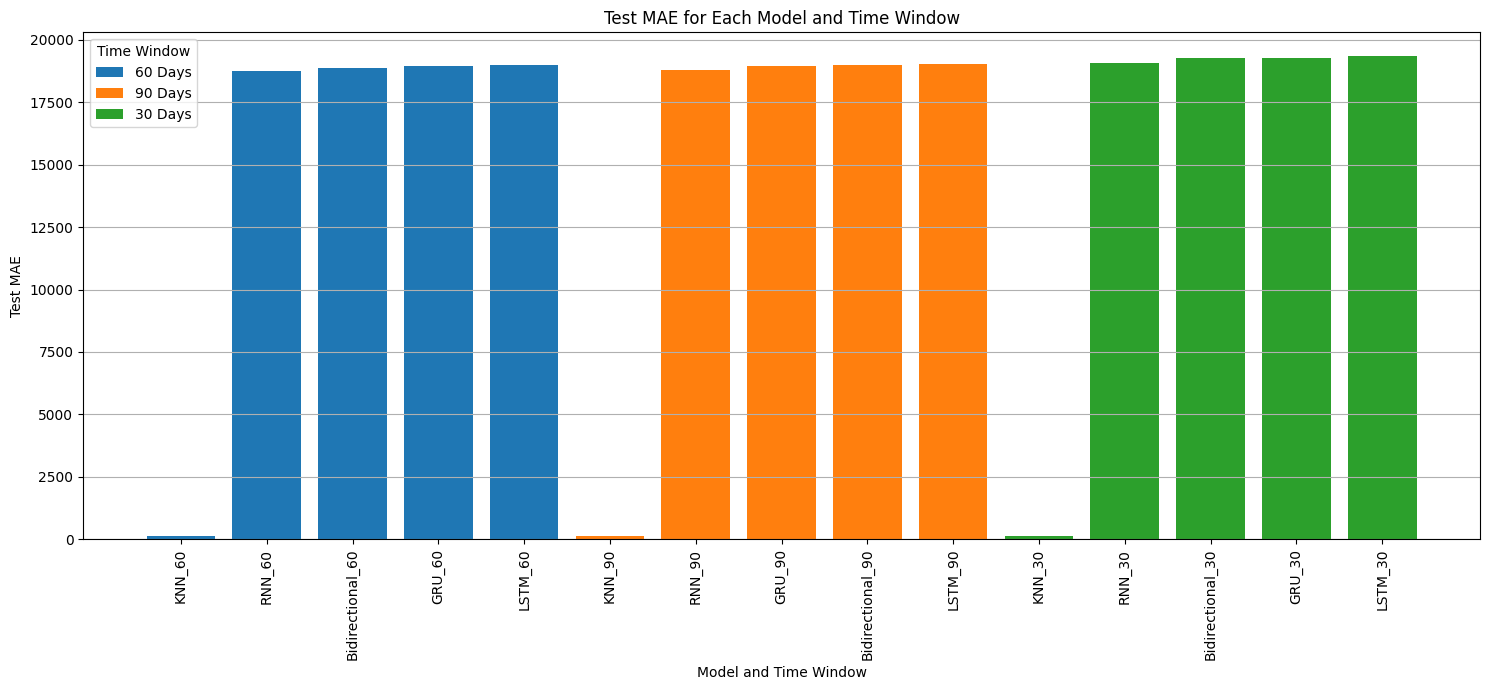

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

top_models = results_df.sort_values(by='test_mae', ascending=True)

# Extract model name, time window, and test MAE
model_data = []
for index, row in top_models.iterrows():
    model_name_parts = row['Model'].split('_')
    model_type = model_name_parts[0]
    time_window = model_name_parts[-1]
    model_data.append({
        'Model Type': model_type,
        'Time Window': time_window,
        'Test MAE': row['test_mae']
    })

model_df = pd.DataFrame(model_data)

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(15, 7))

model_types = model_df['Model Type'].unique()
time_windows = model_df['Time Window'].unique()

bar_width = 0.2

x = np.arange(len(model_types))

for i, window in enumerate(time_windows):
    subset = model_df[model_df['Time Window'] == window]
    # Ensure the subset is ordered by model_types for correct alignment
    subset = subset.set_index('Model Type').loc[model_types].reset_index()
    ax.bar(x + i * bar_width, subset['Test MAE'], bar_width, label=f'{window} Days')

# Labels and aesthetics
ax.set_xlabel('Model Type')
ax.set_ylabel('Test MAE')
ax.set_title('Test MAE for Each Model Type Across Time Windows')
ax.set_xticks(x + bar_width * (len(time_windows) - 1) / 2)
ax.set_xticklabels(model_types)
ax.legend(title='Time Window')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# Conclusion:

Based on the model training with 50 epochs for the Deep Learning models, the results show that:

*   **KNN models consistently outperformed the Deep Learning models (RNN, LSTM, GRU, Bidirectional LSTM)** in terms of Test MAE across all tested time windows (30, 60, and 90 days).
*   Among the KNN models, **KNN with a 60-day time window (`KNN_High_60`) achieved the lowest Test MAE**, suggesting it was the best performing model in this set.
*   The Deep Learning models had significantly higher Test MAE values compared to KNN. This could indicate that 50 epochs might not be sufficient for these models to converge or learn the patterns effectively for this specific task and dataset, or that the current architecture is not optimal.